### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

# Ответ 

На $k$-й итерации для всех $i$:

1) MSE $-\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i)=  -2*(F_{k-1}(x_i) - y_i) = 2*(y_i - F_{k-1}(x_i)) $

2) Экспоненциальная $ -\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i)=-\exp(-y_i F_{k-1}(x_i))(-y_i) =  y_i*\exp(-y_i F_{k-1}(x_i))$

3) Логистическая $ -\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i) = \dfrac{y_i*\exp(-y_i F_{k-1}(x_i))}{1 + \exp(-y_i F_{k-1}(x_i)} = \dfrac{y_i}{1 + \exp(y_i F_{k-1}(x_i))}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [52]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC

In [53]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        
        self.loss = loss
        self.F = list() 
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.base_args = args
        self.base_kwargs = kwargs
    
    def init_model(self, init_model,X,y):
        N = X.shape[0]
        M = X.shape[1]
        if init_model is not None:
            init_model.fit(X,y)
            self.F_l = init_model.predict(X).astype('float64')
            self.F.append((1.0, init_model, np.arange(M)))
        else:
            self.F_l = np.zeros(shape=N)
                                    
   
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        
        self.F_l = None         
        self.init_model(init_model, X, y)
        
        N = X.shape[0]
        M = X.shape[1]
        a = np.tile(np.arange(N), M).reshape(-1,N).T
        b = np.tile(np.arange(M), N).reshape(-1,M)
        
        n_x = int(self.subsample * N)
        n_f = int(self.colsample * M)
        
        for step in range(self.n_estimators):
            model = base_model(*self.base_args, **self.base_kwargs)
                                
            x = np.random.choice(N, n_x)
            feature = np.sort(np.random.choice(M, n_f, replace=False))
                                    
            smpl = X[a[x, :n_f], b[:n_x, feature]]
                                    
            last = self.F_l[x]
            y_i = y[x]
                                    
            if self.loss == 'MSE':
                delta = 2 * (y_i - last)                        
                                    
            if self.loss == 'EXP':
                delta = y_i * np.exp(-y_i * last)
                                    
            if self.loss == 'LOG':
                delta = y_i / (np.exp(y_i * last) + 1.0)
   
                                    
            model.fit(smpl, delta)
            self.F.append((self.learning_rate, model, feature))
            self.F_l += self.learning_rate * model.predict(X[:, feature])
        
        
    def predict(self, X):
        
        N = X.shape[0]
        M = X.shape[1]
        a = np.tile(np.arange(N), M).reshape(-1,N).T
        b = np.tile(np.arange(M), N).reshape(-1,M)
        predict  = 0
        for rate, model, feature in self.F:
            smpl = X[a[:, :feature.shape[0]], b[:, feature]]
            predict += rate * model.predict(smpl)
        if self.loss == 'MSE':
            return (predict + 0.5).astype('int')
        if self.loss == 'EXP':
            return 2 * (predict > 0).astype('int') - 1
        if self.loss == 'LOG':
            return 2 * (predict > 0).astype('int') - 1


In [54]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [55]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [56]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [57]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [58]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [59]:
y_1 = 2 * y - 1

# n_estimators

In [60]:
kFold = KFold(n_splits=5, shuffle=False)
result = []
for n_estimators in  np.arange(50, 200, 10):
    res = []
    for train, test in kFold.split(X):
        
        X_train, X_test,y_train, y_test = X[train], X[test], y[train], y[test]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        myclf = MyGradientBoostingClassifier(n_estimators=n_estimators, max_depth=6)
        myclf.fit(X_train, y_train)

        X_test = scaler.transform(X_test)
        pred = myclf.predict(X_test)
        
        res.append(accuracy_score(y_test, pred))
        
    result.append(np.mean(res))

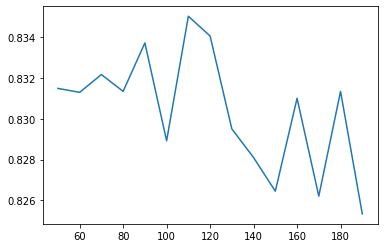

In [62]:
import matplotlib.pyplot as plt
x_ = np.arange(50, 200, 10)
y_ = result
plt.plot(x_,y_)
plt.show()

# loss

In [85]:
kFold = KFold(n_splits=5, shuffle=False)
result = []
for loss in ['LOG', 'EXP', 'MSE'] :
    res = []
    for train, test in kFold.split(X):
        if loss == 'MSE':
            X_train, X_test,y_train, y_test = X[train], X[test], y[train], y[test]
        if loss == 'EXP': 
            X_train, X_test,y_train, y_test = X[train], X[test], y_1[train], y_1[test]
        if loss == 'LOG': 
            X_train, X_test,y_train, y_test = X[train], X[test], y_1[train], y_1[test]
    
        scaler = StandardScaler()
        
        X_train = scaler.fit_transform(X_train)
        
        myclf = MyGradientBoostingClassifier(n_estimators=110,loss=loss,max_depth=6)
      
            
        myclf.fit(X_train, y_train)

        X_test = scaler.transform(X_test)
        pred = myclf.predict(X_test)
        
        res.append(accuracy_score(y_test, pred))
        
    result.append((loss,np.mean(res)))

In [86]:
result

[('LOG', 0.8303779069767442),
 ('EXP', 0.8400678294573642),
 ('MSE', 0.8322674418604652)]

# max_depth

In [87]:
kFold = KFold(n_splits=5, shuffle=False)
result = []
for max_depth in range(4,10) :
    res = []
    for train, test in kFold.split(X):
        
        X_train, X_test,y_train, y_test = X[train], X[test], y[train], y[test]

        scaler = StandardScaler()
        
        X_train = scaler.fit_transform(X_train)
        
        myclf = MyGradientBoostingClassifier(n_estimators=110,
                                             learning_rate=0.05,
                                             max_depth=max_depth)
      
        myclf.fit(X_train, y_train)

        X_test = scaler.transform(X_test)
        pred = myclf.predict(X_test)
        
        res.append(accuracy_score(y_test, pred))
        
    result.append((max_depth,np.mean(res)))

In [88]:
result

[(4, 0.8295542635658915),
 (5, 0.8376937984496123),
 (6, 0.8426356589147288),
 (7, 0.8426356589147288),
 (8, 0.8345930232558139),
 (9, 0.8378391472868219)]

# learning rate

In [89]:
kFold = KFold(n_splits=5, shuffle=False)
result = []

for learning_rate in  [0.05, 0.1, 0.3, 0.5]:
    res = []
    for train, test in kFold.split(X):

    
        X_train, X_test,y_train, y_test = X[train], X[test], y[train], y[test]
           
        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)

        myclf = MyGradientBoostingClassifier(n_estimators=110,learning_rate=learning_rate,max_depth=7)


        myclf.fit(X_train, y_train)

        X_test = scaler.transform(X_test)
        pred = myclf.predict(X_test)

        res.append(accuracy_score(y_test, pred))

    result.append((loss,learning_rate,np.mean(res)))

In [90]:
result

[('MSE', 0.05, 0.8346899224806201),
 ('MSE', 0.1, 0.8374031007751939),
 ('MSE', 0.3, 0.7715116279069767),
 ('MSE', 0.5, 0.6570251937984496)]

# colsample

In [91]:
kFold = KFold(n_splits=5, shuffle=False)
result = []
for colsample in [0.25, 0.5, 0.75, 1.0] :
    res = []
    for train, test in kFold.split(X):
        
        X_train, X_test,y_train, y_test = X[train], X[test], y[train], y[test]

        scaler = StandardScaler()
        
        X_train = scaler.fit_transform(X_train)
        
        myclf = MyGradientBoostingClassifier(n_estimators=110,
                                             colsample = colsample, 
                                             learning_rate=0.05,
                                             max_depth=7)
      
            
        myclf.fit(X_train, y_train)

        X_test = scaler.transform(X_test)
        pred = myclf.predict(X_test)
        
        res.append(accuracy_score(y_test, pred))
        
    result.append((colsample,np.mean(res)))

In [92]:
result

[(0.25, 0.8011143410852712),
 (0.5, 0.8276162790697674),
 (0.75, 0.8310562015503876),
 (1.0, 0.8417635658914728)]

# subsample

In [93]:
kFold = KFold(n_splits=5, shuffle=False)
result = []
for subsample in [0.25, 0.5, 0.75, 1.0] :
    res = []
    for train, test in kFold.split(X):
    
        X_train, X_test,y_train, y_test = X[train], X[test], y[train], y[test]
       
        scaler = StandardScaler()
        
        X_train = scaler.fit_transform(X_train)
        
        myclf = MyGradientBoostingClassifier(n_estimators=110,
                                             subsample = subsample, 
                                             colsample = 0.75,
                                             learning_rate=0.05,
                                             max_depth=7)
      
            
        myclf.fit(X_train, y_train)

        X_test = scaler.transform(X_test)
        pred = myclf.predict(X_test)
        
        res.append(accuracy_score(y_test, pred))
        
    result.append((subsample,np.mean(res)))

In [94]:
result

[(0.25, 0.831734496124031),
 (0.5, 0.8307170542635658),
 (0.75, 0.8363856589147286),
 (1.0, 0.8362403100775195)]

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y_1, test_size=0.33, random_state=42)

In [96]:
clf = MyGradientBoostingClassifier(loss ='MSE', 
                                   n_estimators=110, 
                                   learning_rate=0.1, 
                                   max_depth= 5,
                                   colsample=0.75,
                                   subsample= 0.5)
clf.fit(X_train, y_train, init_model=LinearRegression())
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8881385789782736

In [97]:
clf = MyGradientBoostingClassifier(loss ='MSE', 
                                   n_estimators=110, 
                                   learning_rate=0.1, 
                                   max_depth= 5,
                                   colsample=0.75,
                                   subsample= 0.5)
clf.fit(X_train, y_train, init_model=SVC())
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8909277745155608

In [98]:
clf = MyGradientBoostingClassifier(loss ='MSE', 
                                   n_estimators=110, 
                                   learning_rate=0.1, 
                                   max_depth= 5,
                                   colsample=0.75,
                                   subsample= 0.5)
clf.fit(X_train, y_train, init_model=RandomForestClassifier())
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8810921902524956

In [99]:
clf = MyGradientBoostingClassifier(loss ='EXP', 
                                   n_estimators=110, 
                                   learning_rate=0.1, 
                                   max_depth= 5,
                                   colsample=0.75,
                                   subsample= 0.5)
clf.fit(X_train_1, y_train_1, init_model=LinearRegression())
y_pred = clf.predict(X_test_1)
accuracy_score(y_pred, y_test_1)

0.8857897827363477

In [100]:
clf = MyGradientBoostingClassifier(loss ='EXP', 
                                   n_estimators=110, 
                                   learning_rate=0.1, 
                                   max_depth= 5,
                                   colsample=0.75,
                                   subsample= 0.5)
clf.fit(X_train_1, y_train_1, init_model=SVC())
y_pred = clf.predict(X_test_1)
accuracy_score(y_pred, y_test_1)

0.882413388138579

In [101]:
clf = MyGradientBoostingClassifier(loss ='EXP', 
                                   n_estimators=110, 
                                   learning_rate=0.1, 
                                   max_depth= 5,
                                   colsample=0.75,
                                   subsample= 0.5)
clf.fit(X_train_1, y_train_1, init_model=RandomForestClassifier())
y_pred = clf.predict(X_test_1)
accuracy_score(y_pred, y_test_1)

0.8831473869641808

Мы действительно улучшили score.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

